# 프로젝트9 - 인물사진을 만들어 보자

하나의 카메라로 셸로우 포커스를 만드는 방법
1. 배경이있는 사진 준비
2. 피사체 분리
3. 배경 블러처리
4. 피사체와 배경 합성

# Step1. 라이브러리 불러오기

LMS와 똑같이 진행하기위해서 해당라이브러리들을 동일한 버전으로 맞춰줍니다.

In [ ]:
!pip install pixellib==0.7.1

그대로 pixellib를 실행하게되면 AlreadyExistsError:Another metric with the same name already exists 에러가 떠버리게된다. 이는 keras가 두개이상 설치되어있다는 의미로 keras를 지워준다음에 재설치를 해줘야한다.

In [ ]:
!pip uninstall keras -y

In [ ]:
!pip install keras==2.6.0

In [ ]:
!pip install tensorflow==2.6

In [ ]:
!pip install opencv-python==4.5.3.56

In [42]:
import tensorflow
import keras
import os
import urllib # 웹에서 데이터를 다운로드할때 사용
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# Step2. 사진불러오기

(3024, 4032, 3)


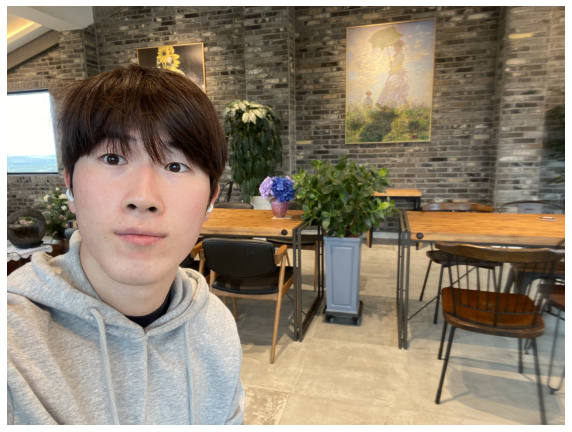

In [43]:
img_path = '/content/drive/MyDrive/Exploration_Data/ex9/sample1.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# Step3. 피사체 분리하기
## 1.모델 다운로드
먼저 PixelLib에서 제공해주는 모델을 다운로드합니다.

In [44]:

model_dir = '/content/drive/MyDrive/Exploration_Data/ex9'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/Exploration_Data/ex9/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa139761d50>)

## 2.세그멘테이션 모델 생성

In [45]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

## 3.모델에 이미지 입력
segmentAsPascalvoc() : PASCAL VOC데이터로 학습된 모델을 사용합니다.

In [46]:
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL VOC데이터의 라벨종류는 다음과같습니다.

In [47]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

여기서 저희가 원하는 라벨은 15,즉 person입니다. 일단 아까 모델에서 나온 출력값을 살펴봅시다.

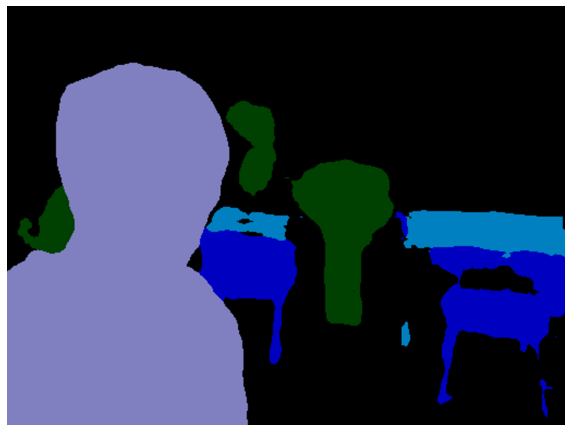

In [48]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output)
plt.show()

In [49]:
segvalues

{'class_ids': array([ 0,  9, 11, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

class_ids가 각각 무엇을 뜻하는지도 확인해봅시다.

In [50]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person
pottedplant


세그멘테이션을 통해 총 5개의 물체를 구분해냈습니다. 이제 Label 15번에 해당하는 부분이 어떤 색상으로 나타나있는지 확인해봅시다.

In [51]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15]

array([192, 128, 128])

주의할점은 output이미지는 BGR순서로 배치되어있기때문에, RGB로 바꾸어줘야한다.

In [52]:
seg_color = (128,128,192)

해당 색상으로만 이루어진 마스크를 만들어봅시다.

(3024, 4032)


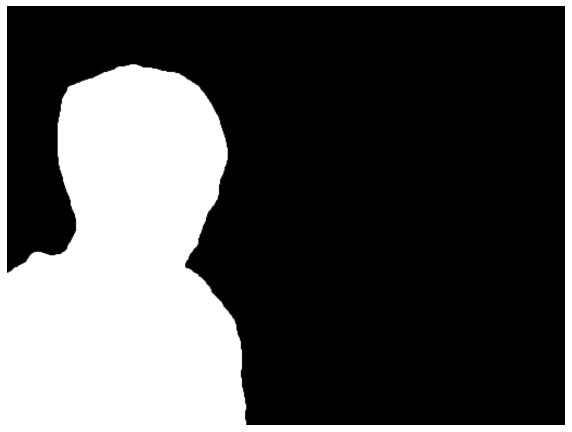

In [53]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(seg_map, cmap='gray')
plt.show()

원본 이미지와 겹쳐봐서 세그멘테이션이 얼마나 잘 되었는지 눈으로 확인해봅시다.

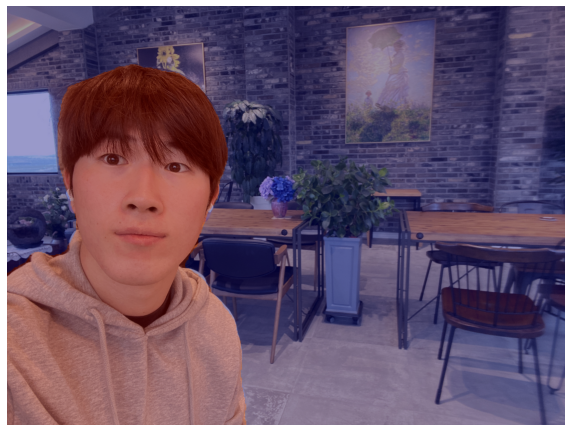

In [54]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다.
# cv2.applyColorMap를 활용해 원본 이미지에 특정 색상 맵 배열이 적용된 이미지를 생성합니다.
# cv2.applyColorMap(img, colormap)은 입력 이미지에 색상 맵을 적용한 결과를 반환합니다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

피사체가 잘 분리된것을 확인할 수 있습니다.

# Step4. 배경 블러처리
원본이미지를 가져와 전체를 흐리게만들어봅시다.

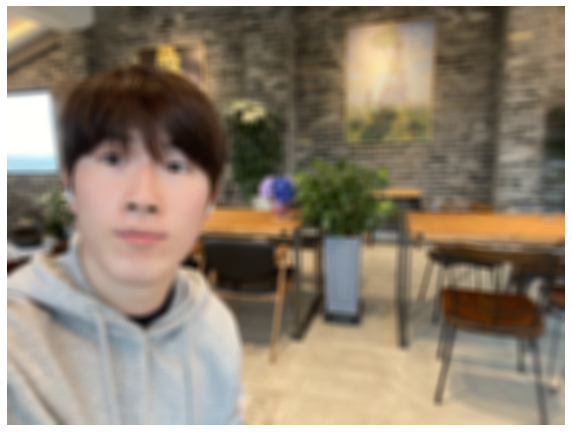

In [55]:
img_orig_blur = cv2.blur(img_orig, (60,60)) # (60,60)은 blurring kernel size를 뜻합니다  
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출해보겠습니다.

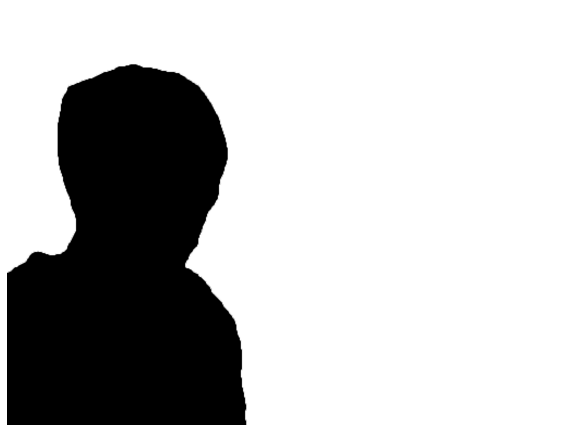

In [56]:
# bitwise_not()함수를 이용하면 이미지가 반전됩니다. 따라서 배경은 255, 사람은 0이됩니다.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
plt.show()

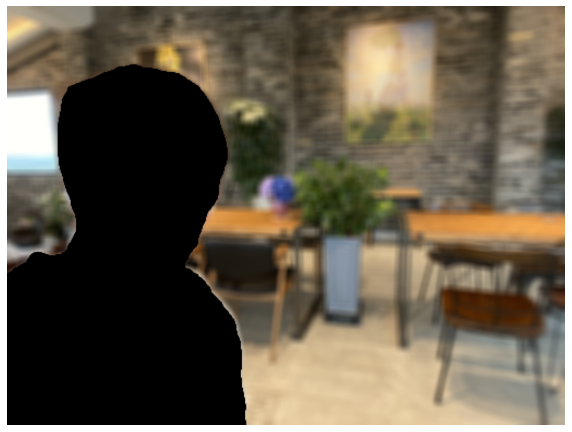

In [57]:
# 블러처리한 이미지와 반전시킨 마스크를 bitwise_and시키면, 사람이있는 모든부분은 픽셀이 0이됩니다.
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# Step5. 흐린배경과 원본이미지 합성

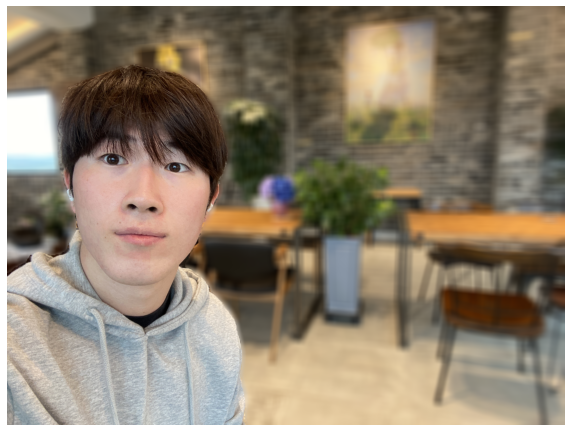

In [58]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

인물모드가 완성되었습니다. 원본과 비교해봅시다.

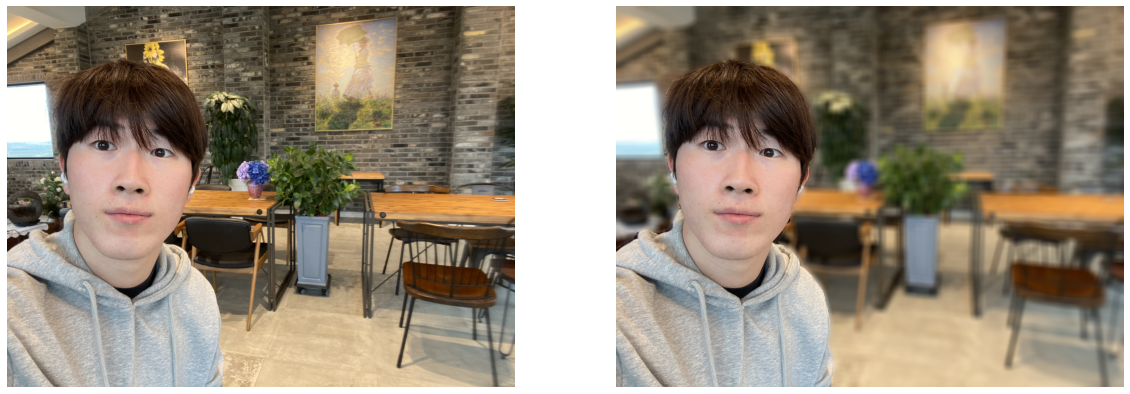

In [59]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

성공적으로 잘 작동된것같습니다.

# Step6. 다양한 사진 시도해보기

# Cat

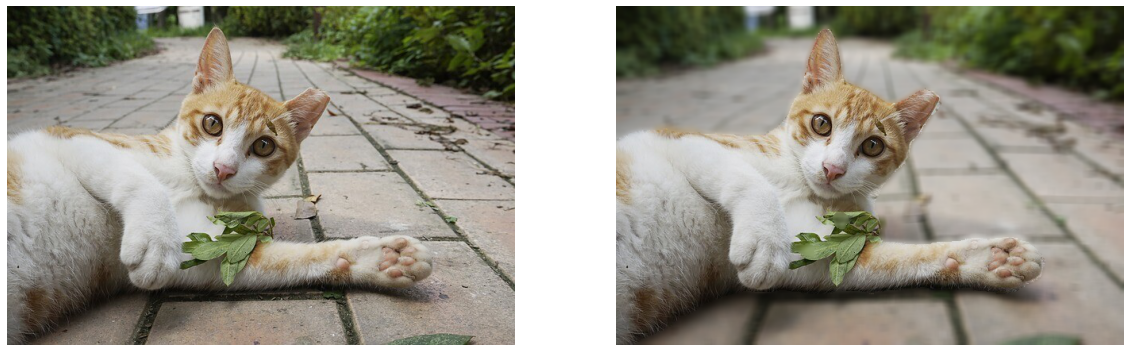

In [60]:
img_path = '/content/drive/MyDrive/Exploration_Data/ex9/cat.png'  
img_orig = cv2.imread(img_path) 
segvalues, output = model.segmentAsPascalvoc(img_path)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
# colormap[8] >>> (64, 0, 0)
seg_color = (0, 0, 64)
seg_map = np.all(output==seg_color, axis=-1)
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
img_orig_blur = cv2.blur(img_orig, (10,10))  
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

# Dog

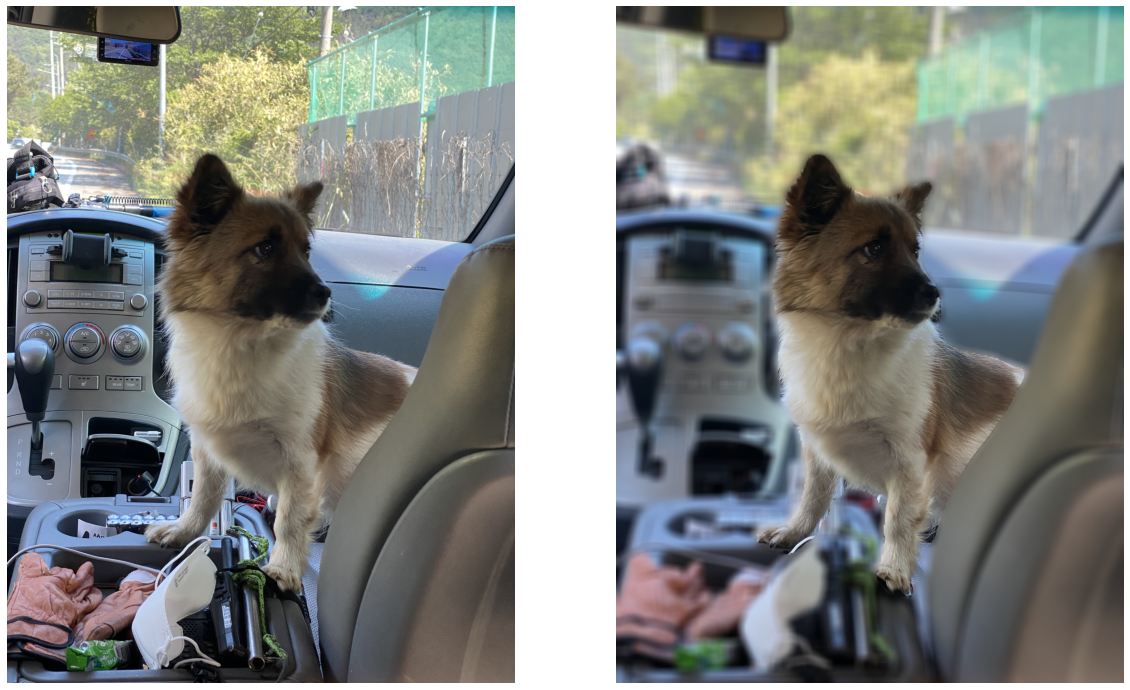

In [61]:
img_path = '/content/drive/MyDrive/Exploration_Data/ex9/dog.png'  
img_orig = cv2.imread(img_path) 
segvalues, output = model.segmentAsPascalvoc(img_path)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
# colormap[12] >>> (64, 0, 128)
seg_color = (128, 0, 64)
seg_map = np.all(output==seg_color, axis=-1)
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
img_orig_blur = cv2.blur(img_orig, (60,60))  
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

# Step7. 문제점 & 솔루션

(-0.5, 639.5, 426.5, -0.5)

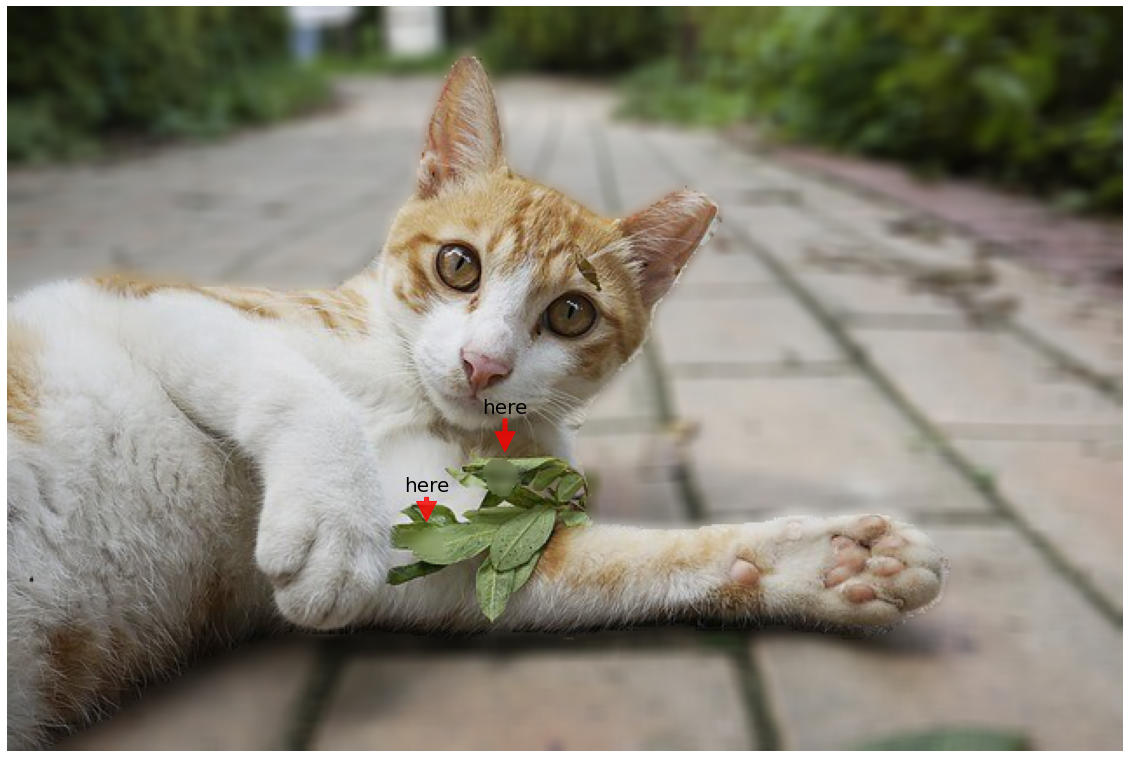

In [62]:
img_path = '/content/drive/MyDrive/Exploration_Data/ex9/cat.png'  
img_orig = cv2.imread(img_path) 
segvalues, output = model.segmentAsPascalvoc(img_path)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
# colormap[8] >>> (64, 0, 0)
seg_color = (0, 0, 64)
seg_map = np.all(output==seg_color, axis=-1)
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
img_orig_blur = cv2.blur(img_orig, (10,10))  
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.annotate('here',
ha = 'center', va = 'bottom',
xytext = (285, 235),
xy = (285, 255),
fontsize=20,
arrowprops = {'facecolor' : 'r', 
              'edgecolor':'r',  
              'alpha':0.8,
              'shrink' : 1.5,
              'headwidth':20,
              'headlength':20
              })
plt.annotate('here',
ha = 'center', va = 'bottom',
xytext = (240, 280),
xy = (240, 295),
fontsize=20,
arrowprops = {'facecolor' : 'r', 
              'edgecolor':'r',  
              'alpha':0.8,
              'shrink' : 2.0,
              'headwidth':20,
              'headlength':20
              })
plt.axis('off')

고양이 팔쪽에 있는 나뭇잎위에 두가지부분이 블러처리 되어있습니다.
## **[솔루션]**
저런식으로 물체안쪽에 또다른 물체가 있을경우, 모델이 제외시킬 수 도있는것같습니다. 결국 고양이든 나뭇잎을 든 고양이든간에 우리는 고양이를 셀로우 포커스를 하고싶은것이기때문에, 결국 나뭇잎 또한 고양이의 일부분으로 생각해야 좀 더 자연스러운 인물사진이 나올꺼같습니다. 따라서 일반적인 해결법은 모델이 특정물체를 인식했을때, 그 물체의 테두리 안에 있는 모든 영역이 해당물체로 처리된다면 위의 그림처럼 두개의 구멍이 생기지않을것입니다.

이와같은 패키지나 함수를 찾아보려 구글링을하였으나, 마땅히 내가 원하는 기능을하는 함수를 찾지못하였다. 따라서 직접 함수를 만들어서 구현을해보려고한다.

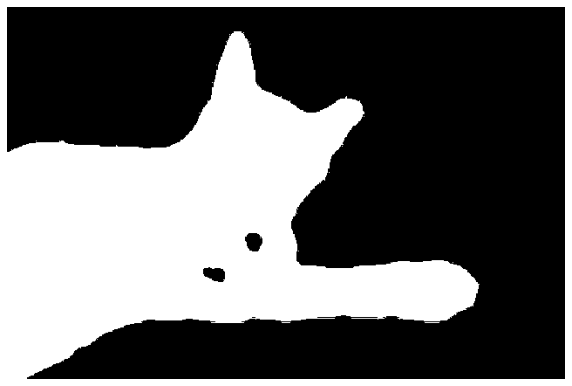

In [63]:
img_path = '/content/drive/MyDrive/Exploration_Data/ex9/cat.png'  
img_orig = cv2.imread(img_path) 
segvalues, output = model.segmentAsPascalvoc(img_path)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
# colormap[8] >>> (64, 0, 0)
seg_color = (0, 0, 64)
seg_map = np.all(output==seg_color, axis=-1)
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크를 뽑아보면 물체부분이255, 배경이0 픽셀값을 가진다. 따라서 여기서 처리해야할부분은 저 고양이 영역안에 0인 픽셀값을 전부 255로 바꾸어주어야한다.

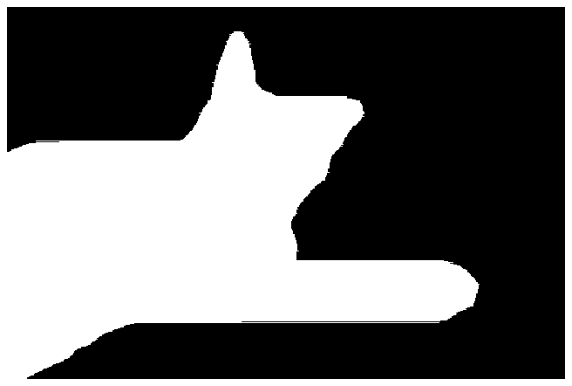

In [84]:
# 해당함수는 각 행에서 픽셀값이 255인값을 뽑아내고, 해당 픽셀들의 최대,최소 인덱스를 구한뒤 그 사이에있는 모든 픽셀값을 255로 만들어줍니다.
def fill_the_img(img):
  for i in range(img.shape[0]):
    idx_list = []
    for idx, x in enumerate(img[i,:]==255):
      if x == True:
        idx_list.append(idx)
        idx_min = min(idx_list)
        idx_max = max(idx_list)
        for row in range(idx_min,idx_max):
          if img[i,row]==0:
            img[i,row] = 255

  return img

img_mask_revised = fill_the_img(img_mask)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_mask_revised, cv2.COLOR_BGR2RGB))
plt.show()

고양이안에있는 구멍들은 사라졌지만, 원래 고양이물체가 가지고있는 영역보다 더 커지게되었다. 테두리는 그대로 유지하면서 안에있는 구멍들만 없애주려하였지만, 더 이상 아이디어가 떠오르지않는다...

# 회고
- sementic segmentation의 개념에대해서 배울 수 있었고, 해당 작업에 대한 최신모델인 DeepLab V3+을 사용해보았다. 여러 이미지를 적용해본결과 거의 모든 물체들을 분류한것으로 보아 성능이 매우 좋은 모델인거 같다.

- 이미지에서 피사체를 분리해내는 법과 배경을 블러처리하는것에 대해 배웠다. 블러처리 커널사이즈는 이미지의 화질에따라 정해주어야하는것같다. 화질이 높은 이미지에다가 커널사이즈를 작게주었더니 원본과 거의 달라지지않았다. 그래서 커널사이즈를 조금씩 높여주면서 적절한 커널사이즈를 찾아나갔다.

- 초반에 pixellib를 불러오는데 많이 애를먹었다. pip로 그저 install만 해주면 될줄알았지만 LMS노드에서와 버전차이때문에 여러 에러가 떴었다. 코랩에서 노드를 진행시 라이브러리버전에 대한 고려도해주어야한다는것을 뼈저리게 느끼는 시간이었다...

- 평소에 아이폰으로 인물사진을 자주 찍었었는데, 이런식의 단일렌즈만으로도 인물사진을 구현할 수 있는것이 많이 신기했다. 그외에 고양이와 개에대한 셸로우 포커스도 진행하였고, 결과가 나름 잘나왔다.

- 물체안에 또다른 물체가 있을때 해당물체로 인식이안돼 마치 구멍이 뚤린것같은 현상이 생겼다. 해당문제를 해결할 아이디어자체는 떠올랐지만, 이를 코드로 구현하는것은 또 다른문제였다. 떠오른 아이디어를 종합해 함수로 만들어봤지만 결과는 내 생각과는 조금달랐다. 물체안에 구멍을 없애주는데는 성공했지만, 원래의 물체보다 더 크게 segmentation이 되버리는 또다른 문제가 발생해버렸다...알고리즘 공부가 더 필요하다고 느꼈고, 많은 패키지를 알고있으면 더 쉽게 문제를 해결할수 있었지않을까하는 생각이든다.